In [1]:
import os

from matplotlib import pyplot as plt
from PIL import Image
import cv2
import numpy as np

from utils import read_array, find_ground_plane, quaternion_rotation_matrix, calculate_distances

In [345]:
with open("./dense/txt/points3D.txt", "r") as f:
    temp_pts = f.readlines()[3:]
pts3d = np.array([x.split(" ")[1:4] for x in temp_pts], dtype=np.float32)
rgb3d = np.array([x.split(" ")[4:7] for x in temp_pts], dtype=np.float32)/255

with open("./txt/images.txt", "r") as f:
    temp_images = f.readlines()[4:][::2]
img_ids = np.array([x.split(" ")[0] for x in temp_images], dtype=np.int16)
poses = np.array([x.split(" ")[1:8] for x in temp_images], dtype=np.float32)

with open("./txt/cameras.txt", "r") as f:
    temp_cameras = f.readlines()[-1]
cam_params = np.array(temp_cameras.split(" ")[-4:], dtype=np.float32)

In [326]:
plane, inliers, num_inliers = find_ground_plane(pts3d, max_iters=1000, t=0.5)
print(plane, num_inliers)

above_pts3d = calculate_distances(pts3d, plane) > 1

[ 0.00472065 -0.20718893 -0.02884576  1.        ] 116071


In [327]:
class Maps():
    def __init__(self, depth_root, mask_root, image_root) -> None:
        self.depth_root = depth_root
        self.mask_root = mask_root
        self.image_root = image_root

        self.depth_maps = depth_maps = [filename for filename in os.listdir(self.depth_root) if "geometric" in filename]
        self.masks = [filename[:-14] for filename in depth_maps]
        self.images = [filename[:-14] for filename in depth_maps]

    def __len__(self):
        return len(self.depth_maps)
    
    def __getitem__(self, idx):
        depth_map = read_array(os.path.join(self.depth_root, self.depth_maps[idx]))

        mask = np.array(Image.open(os.path.join(self.mask_root, self.masks[idx])))
        bool_mask = mask > 0
        mask = np.int8(bool_mask)
        
        resized_depth_map = np.clip(cv2.resize(depth_map, mask.shape[::-1]), a_min=0, a_max=16)

        image = np.array(Image.open(os.path.join(self.image_root, self.images[idx])))

        return resized_depth_map, mask, image

In [328]:
depth_maps_path = "./dense/stereo/depth_maps/"
masks_path = "../Apple/detection/train/masks/"
images_path = "../Apple/detection/train/images/"
maps = Maps(depth_maps_path, masks_path, images_path)

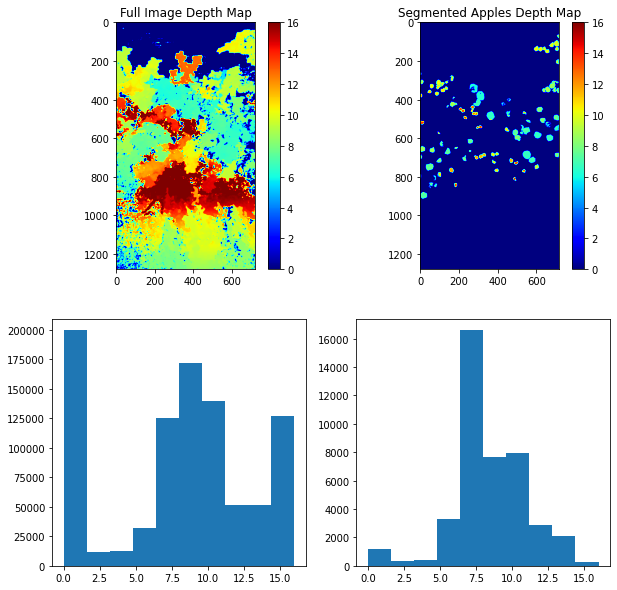

In [329]:
depth_map, mask, image = maps[0]

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)
ax1.set_title("Full Image Depth Map")
plt.imshow(np.clip(depth_map, a_min=0, a_max=16), cmap="jet")
plt.colorbar()

ax2 = fig.add_subplot(222)
ax2.set_title("Segmented Apples Depth Map")
plt.imshow(mask * depth_map, cmap="jet")
plt.colorbar()

ax3 = fig.add_subplot(223)
plt.hist(depth_map.reshape(-1))

ax4 = fig.add_subplot(224)
plt.hist(depth_map[np.bool8(mask)])
plt.show()


Goal:
Given the 3d point cloud, map the points to the cameras perspective

In [330]:
pose = poses[0]
R = quaternion_rotation_matrix(pose[:4])
T = pose[-3:]

extrinsic = np.zeros((4,4))
extrinsic[:3,:3] = R
extrinsic[:3, -1] = T
extrinsic[3,3] = 1

K = np.zeros((3,4))
K[(0,1),(0,1)] = cam_params[0] #/cam_params[3] # changed / from *
K[:2, 2] = cam_params[1:3]
K[2,2] = 1

In [331]:
K

array([[1.19876172e+03, 0.00000000e+00, 3.60000000e+02, 0.00000000e+00],
       [0.00000000e+00, 1.19876172e+03, 6.40000000e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [332]:
cam_pts = np.pad(pts3d, pad_width=((0,0), (0,1)), mode="constant", constant_values=1) @ extrinsic.T
pixel_pts = cam_pts @ K.T
pixel_pts = pixel_pts / pixel_pts[:,2:3]

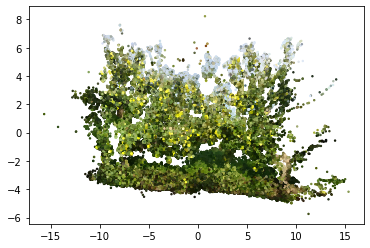

In [333]:
cam_inliers = cam_pts[:,1] < 10

plt.scatter(cam_pts[cam_inliers,0], -cam_pts[cam_inliers,1], c=rgb3d[cam_inliers], s=2)

In [335]:
i_under = pixel_pts[:,0] < 720
i_over = pixel_pts[:,0] > 0
j_under = pixel_pts[:,1] < 1280
j_over = pixel_pts[:,1] > 0

pixel_inliers = i_under*i_over*j_under*j_over

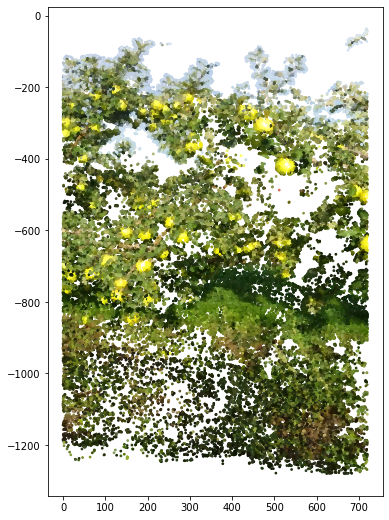

In [336]:
plt.figure(figsize=(6,9))
plt.scatter(pixel_pts[pixel_inliers,0], -pixel_pts[pixel_inliers,1], c=rgb3d[pixel_inliers], s=3)

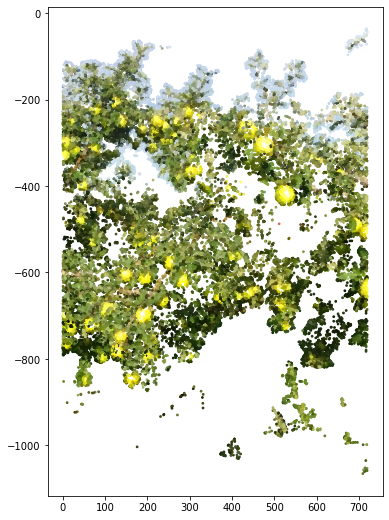

In [337]:
plt.figure(figsize=(6,9))
plt.scatter(pixel_pts[pixel_inliers*above_pts3d,0], -pixel_pts[pixel_inliers*above_pts3d,1], c=rgb3d[pixel_inliers*above_pts3d], s=3)

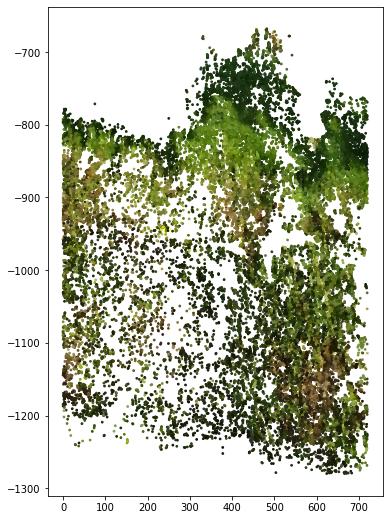

In [338]:
sel = np.bool8(pixel_inliers * (1-above_pts3d))
plt.figure(figsize=(6,9))
plt.scatter(pixel_pts[sel,0], -pixel_pts[sel,1], c=rgb3d[sel], s=3)

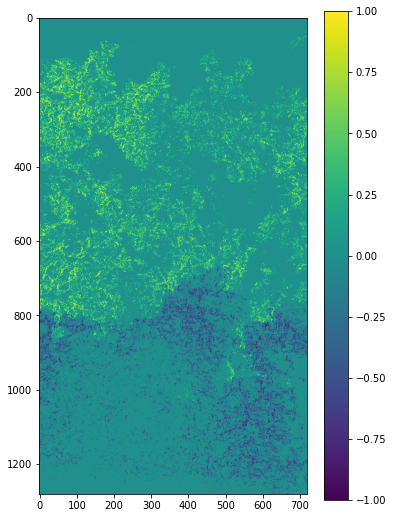

In [339]:
ground_likelihood = np.zeros(shape=(1280, 720))
r = 10
ground_points = np.uint16(pixel_pts[np.bool8(pixel_inliers * (1-above_pts3d)), :2])
unground_points = np.uint16(pixel_pts[pixel_inliers*above_pts3d, :2])
for p in ground_points:
    i,j = np.uint16(p)
    ground_likelihood[j,i] = -1
for p in unground_points:
    i,j = np.uint16(p)
    ground_likelihood[j,i] = 1

plt.figure(figsize=(6,9))
plt.imshow(ground_likelihood)
plt.colorbar()

In [351]:
from scipy.ndimage import gaussian_filter

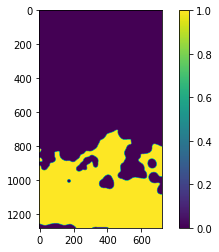

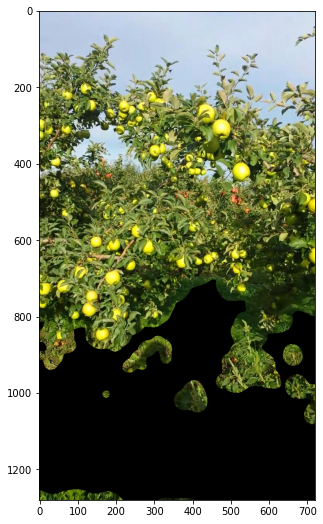

In [403]:
ground = 1000*(ground_likelihood == -1)
unground = 1000*(ground_likelihood == 1)

g_unground = gaussian_filter(unground, sigma=10)>0
g_ground = gaussian_filter(ground, sigma=20)>0

pred = (np.zeros_like(g_ground) - np.array(g_ground, dtype=np.float32) + np.array(g_unground, dtype=np.float32)) < 0
plt.imshow(pred)
plt.colorbar()
plt.show()

_,_,img = maps[2]
plt.figure(figsize=(6,9))
plt.imshow(img*(1-pred.reshape(1280,720,1))/255)

In [404]:
from sklearn.neighbors import KNeighborsClassifier

labels = np.ones(shape=(len(pixel_pts[pixel_inliers]), ))
labels[:len(pixel_pts[pixel_inliers*above_pts3d])] = 0

classifier = KNeighborsClassifier(n_neighbors=15)
classifier = classifier.fit(X=np.concatenate([unground_points, ground_points]), y=labels)

x,y=np.meshgrid(np.arange(0,1280), np.arange(0,720))
t = np.stack([y,x], axis=-1).reshape(-1,2)

preds = classifier.predict(t)

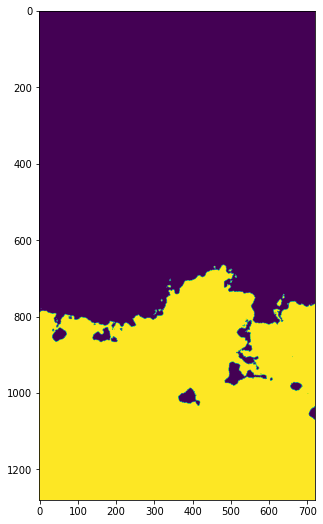

In [377]:
plt.figure(figsize=(6,9))
plt.imshow(preds.reshape(720, 1280).T)

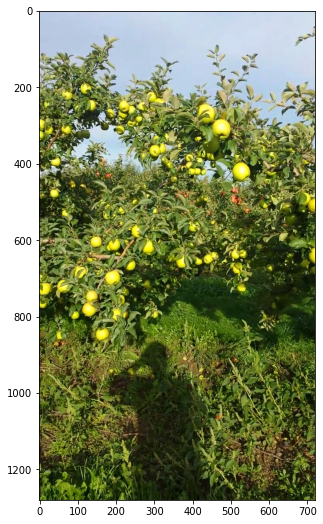

In [342]:
_,_,img = maps[2]
plt.figure(figsize=(6,9))
plt.imshow(img)

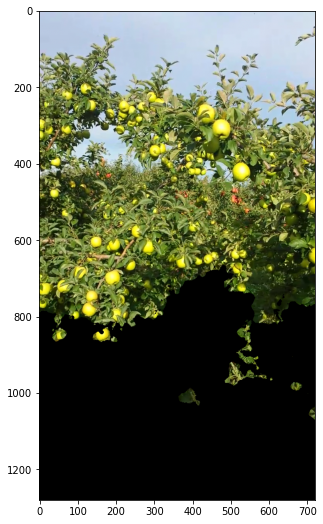

In [378]:
_,_,img = maps[2]
plt.figure(figsize=(6,9))
plt.imshow(img*(1-preds.reshape(1,720, 1280).T)/255)